In [184]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import numpy as np
import pandas as pd
from sklearn import preprocessing, metrics, model_selection
import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline

torch.manual_seed(0)
import random
random.seed(0)

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [3]:
path_train      = 'F://TFG//datasets//data_train//'
path_graphs     = 'F://TFG//graphs//plot_results//'

In [4]:
data = pd.read_csv(path_train+'training_features_DF.csv',sep=';',index_col='wyId')

# X_train = pd.read_csv(path_train+'X_train.csv',sep=';',index_col='wyId')
# y_train = pd.read_csv(path_train+'y_train.csv',sep=';',index_col='wyId')
# X_test = pd.read_csv(path_train+'X_test.csv',sep=';',index_col='wyId')
# y_test = pd.read_csv(path_train+'y_test.csv',sep=';',index_col='wyId')

In [5]:
class FootballMatchesDataset(Dataset):
    def __init__(self,file):
        df              = pd.read_csv(path_train+'X_'+file+'.csv',sep=';')
        lab_df          = pd.read_csv(path_train+'y_'+file+'.csv',sep=';')
        self.data       = torch.tensor(df.values[:,1:]).float() 
        self.labels     = F.one_hot(torch.tensor(lab_df.values[:,1]), num_classes=3).float()
        self.matches    = torch.tensor(lab_df.values[:,0])

    def __len__(self):
        return len(self.data)

    def shape(self):
        return self.data.shape

    def __getitem__(self,idx):
        sample  = self.data[idx]
        label   = self.labels[idx]
        match   = self.matches[idx]
        return sample, label, match



In [6]:
train_data  = FootballMatchesDataset(file = 'train')
test_data   = FootballMatchesDataset(file = 'test')

len(train_data), len(test_data)

(1100, 314)

In [7]:
dataloader = DataLoader(train_data, batch_size=4, shuffle=True, num_workers=0)
train_feat, train_lab, _ = next(iter(dataloader))
train_lab

tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]])

In [8]:
scaler  = preprocessing.StandardScaler()
train_data.data = scaler.fit_transform(train_data.data)

### Neural Network Implementation

Define the class:

#### I) Artificial Neural Network Approach to Football Score Prediction

Multilayer Perceptron with 1 hidden layer with BacpPropagation.
6 units input -> 5 hidden units -> 2 output units w/ sigmoid

Data Normalized [0,1]

In [9]:
train_data  = FootballMatchesDataset(file = 'train')
test_data   = FootballMatchesDataset(file = 'test')

In [10]:
normalizer = preprocessing.Normalizer()
train_data.data = normalizer.fit_transform(train_data.data)

In [11]:
print(train_data.data.mean(), train_data.data.std())
print(train_data.data.max(),  train_data.data.min())

0.06813519 0.20202015
0.96471554 0.0


In [102]:
dataloader_train    = DataLoader(train_data, batch_size=20, shuffle=True)
dataloader_test     = DataLoader(test_data,  batch_size=50, shuffle=True)

train_feat, train_lab, _ = next(iter(dataloader_train))
train_feat[0]

tensor([3.9871e-02, 2.7169e-02, 1.5277e-02, 2.0369e-02, 2.6523e-04, 1.7903e-04,
        3.8192e-03, 1.2731e-03, 4.2436e-04, 3.1827e-04, 7.9504e-01, 6.0408e-01,
        5.3971e-04, 5.1446e-04, 1.9096e-03, 6.3654e-04, 1.5532e-03, 8.6570e-04,
        4.3285e-04, 5.3469e-04, 6.6201e-04, 4.1110e-04])

In [103]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_feature, ouput_classes):
        super().__init__()
        
        self.h1 = nn.Linear(in_features=input_feature,out_features=5)
        self.bn = nn.BatchNorm1d(5)
        self.out = nn.Linear(5,ouput_classes)

    def forward(self,x):
        x = F.relu(self.h1(x))
        x = self.bn(x)
        return F.softmax(self.out(x),1)    

    def reset_weights(self):
        self.h1.reset_parameters()
        self.bn.reset_parameters()
        self.out.reset_parameters()    

In [104]:
model = NeuralNetwork(22,3)

In [105]:
# Print out the architecture and number of parameters.
print(model)
print(f"The model has {sum([x.nelement() for x in model.parameters()]):,} parameters.")

NeuralNetwork(
  (h1): Linear(in_features=22, out_features=5, bias=True)
  (bn): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (out): Linear(in_features=5, out_features=3, bias=True)
)
The model has 143 parameters.


##### Loss Function: Cross-entropy Loss

we can provide `weights`, as prior probability of each class $C$.

In [106]:
train_data.labels   # in 1-hot encoding

tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        ...,
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 1., 0.]])

In [107]:
weights_class = np.mean(train_data.labels.numpy(),axis=0)

criterion = nn.CrossEntropyLoss()

##### Optimizer

In [108]:
learning_rate = 1e-1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
# optimizar con momentum (nesterov), weight decay

##### Accuracy

In [146]:
def get_accuracy(pred,y,conf_matrix=False):
    pred_class = torch.argmax(pred,dim=1).numpy()
    y_class    = torch.argmax(y,dim=1).numpy()
    
    if conf_matrix:
        return (np.mean((pred_class == y_class)), 
                metrics.confusion_matrix(y_class,pred_class))
    else:
        return np.mean((pred_class == y_class)), _
    

##### Train Loop

In [202]:
def train_model(model, criterion, optimizer, dataloader_train, dataloader_test, epochs):

    accuracy_train  = []
    error           = []
    accuracy_test   = []

    confusion_matrix = np.zeros((3,3))

    for ep in range(epochs):
        # Training.
        model.train()
        acc_batch   = []
        
        for it, batch in enumerate(dataloader_train):

            # 5.1 Load a batch, break it down in images and targets.
            x, y, _ = batch
            # batch to device ????
            
            # 5.2 Run forward pass.
            logits = model(x)
            
            # 5.3 Compute loss (using 'criterion').
            loss = criterion(logits, y)
            
            # 5.4 Run backward pass.
            loss.backward()
            
            # 5.5 Update the weights using optimizer.
            optimizer.step()
            
            # 5.6 Zero-out the accumulated gradients.
            optimizer.zero_grad()
            # `model.zero_grad()` also works

            res, _ = get_accuracy(logits,y)
            acc_batch.append(res)

        accuracy_train.append(np.mean(acc_batch)) 
        error.append(float(loss))

        print('\rEp {}/{}, it {}/{}: loss train: {:.2f}, accuracy train: {:.2f}'.
                format(ep + 1, epochs, it + 1, len(dataloader_train), loss,
                        np.mean(acc_batch)), end='')

        # Validation.
        model.eval()
        with torch.no_grad():
            acc_run = 0
            for it, batch in enumerate(dataloader_test):
                # Get batch of data.
                x, y, _          = batch
                curr_bs          = x.shape[0]
                preds            = model(x) 
                res, conf_mat    = get_accuracy(preds, y, conf_matrix=True)
                acc_run          += res * curr_bs
                if ep == epochs-1:
                    confusion_matrix += conf_mat

            acc_test = acc_run / len(dataloader_test.dataset)
            accuracy_test.append(acc_test)

            print(', accuracy test: {:.2f}'.format(acc_test))

    return error,accuracy_train,accuracy_test,confusion_matrix

In [205]:
# Train the model
epochs = 10
learning_rate = 1e-1
optimizer_lenet = torch.optim.SGD(model.parameters(), lr=learning_rate)
error,accuracy_train,accuracy_test,confusion_matrix = train_model(model, criterion, optimizer, dataloader_train, dataloader_test, epochs)

Ep 1/10, it 55/55: loss train: 1.03, accuracy train: 0.48, accuracy test: 0.28
Ep 2/10, it 55/55: loss train: 1.21, accuracy train: 0.48, accuracy test: 0.28
Ep 3/10, it 55/55: loss train: 1.10, accuracy train: 0.50, accuracy test: 0.26
Ep 4/10, it 55/55: loss train: 1.06, accuracy train: 0.48, accuracy test: 0.27
Ep 5/10, it 55/55: loss train: 0.96, accuracy train: 0.49, accuracy test: 0.27
Ep 6/10, it 55/55: loss train: 1.07, accuracy train: 0.48, accuracy test: 0.27
Ep 7/10, it 55/55: loss train: 1.08, accuracy train: 0.49, accuracy test: 0.27
Ep 8/10, it 55/55: loss train: 1.08, accuracy train: 0.48, accuracy test: 0.30
Ep 9/10, it 55/55: loss train: 1.12, accuracy train: 0.48, accuracy test: 0.30
Ep 10/10, it 55/55: loss train: 1.09, accuracy train: 0.49, accuracy test: 0.26


No handles with labels found to put in legend.


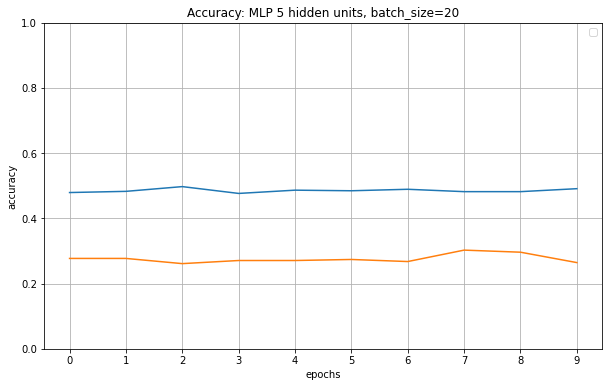

In [207]:
plt.figure(figsize=(10,6))

for p in [accuracy_train,accuracy_test]:
    plt.plot(p)

plt.title('Accuracy: MLP 5 hidden units, batch_size=20')
plt.xticks(np.arange(epochs))
plt.legend()
plt.grid()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.ylim([0,1])

plt.savefig(path_graphs + 'acc_mlp5_bn20.jpg', format='jpg', dpi=200)

##### Applying Cross Validation

In [148]:
folds = 5
kfold = model_selection.KFold(n_splits=folds,shuffle=True,random_state=0)

In [149]:
def train_wCrossValidation(model,criterion,optimizer,train_data,batch_size=20,epochs=5):

    model.reset_weights()

    error           = []
    accuracy_train  = []
    accuracy_test   = []

    confusion_matrix = []

    for fold,(train_idx,test_idx) in enumerate(kfold.split(train_data.data)):
        train_subsampler    = SubsetRandomSampler(train_idx)
        test_subsampler     = SubsetRandomSampler(test_idx)
        
        trainloader = DataLoader(
                            train_data, 
                            batch_size=batch_size, sampler=train_subsampler)
        testloader  = DataLoader(
                            train_data,
                            batch_size=100, sampler=test_subsampler)
        
        model.reset_weights()

        error_fold,acc_train_fold,acc_test_fold,conf_matrix = train_model(
                model, criterion, optimizer, trainloader, testloader, epochs
            )

        confusion_matrix.append(conf_matrix)
        error.append(error_fold)
        accuracy_train.append(acc_train_fold)
        accuracy_test.append(acc_test_fold)
        
        print('\rFold {}/{}: loss train: {:.2f}, accuracy train: {:.2f}, accuracy test: {:.2f}'.
                format(fold + 1, folds, np.mean(error_fold),
                        np.mean(acc_train_fold), np.mean(acc_test_fold)), end='')
        print('\n')
    
    return error, accuracy_train, accuracy_test, np.array(confusion_matrix)
        

In [154]:
error, accuracy_train, accuracy_test, confusion_matrix = train_wCrossValidation(model,criterion, optimizer, train_data, epochs)

Ep 1/5, it 88/88: loss train: 1.03, accuracy train: 0.45, accuracy test: 0.10
Ep 2/5, it 88/88: loss train: 0.98, accuracy train: 0.48, accuracy test: 0.10
Ep 3/5, it 88/88: loss train: 1.10, accuracy train: 0.47, accuracy test: 0.10
Ep 4/5, it 88/88: loss train: 1.01, accuracy train: 0.47, accuracy test: 0.10
Ep 5/5, it 88/88: loss train: 1.04, accuracy train: 0.48, accuracy test: 0.05
Fold 1/5: loss train: 1.03, accuracy train: 0.47, accuracy test: 0.09

Ep 1/5, it 88/88: loss train: 1.02, accuracy train: 0.46, accuracy test: 0.09
Ep 2/5, it 88/88: loss train: 1.05, accuracy train: 0.49, accuracy test: 0.09
Ep 3/5, it 88/88: loss train: 1.01, accuracy train: 0.49, accuracy test: 0.09
Ep 4/5, it 88/88: loss train: 1.02, accuracy train: 0.49, accuracy test: 0.09
Ep 5/5, it 88/88: loss train: 0.98, accuracy train: 0.48, accuracy test: 0.09
Fold 2/5: loss train: 1.02, accuracy train: 0.48, accuracy test: 0.09

Ep 1/5, it 88/88: loss train: 1.09, accuracy train: 0.47, accuracy test: 0.09


In [155]:
weights_class

array([0.24909091, 0.45727274, 0.29363635], dtype=float32)

In [196]:
def dispConfusionMatrix(matrix,title,filename,save=True):
    df_confmat = pd.DataFrame(matrix, index=['draw','local win','away win'], columns=['draw','local win','away win'])
    plt.figure(figsize=(10,7))
    plt.title(title)
    sn.heatmap(df_confmat,annot=True,fmt=".0f")
    plt.savefig(path_graphs + filename + '.jpg', format='jpg', dpi=200)

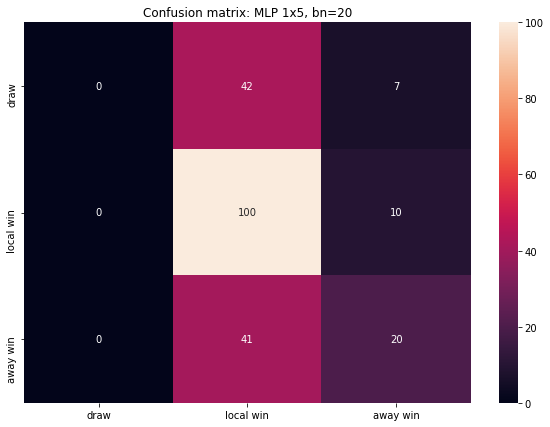

In [197]:
dispConfusionMatrix(confusion_matrix[4],'Confusion matrix: Normaliz. MLP 1x5, bn=20','confmat_norm_mlp5_bn20')

No handles with labels found to put in legend.


(0.5, 1.5)

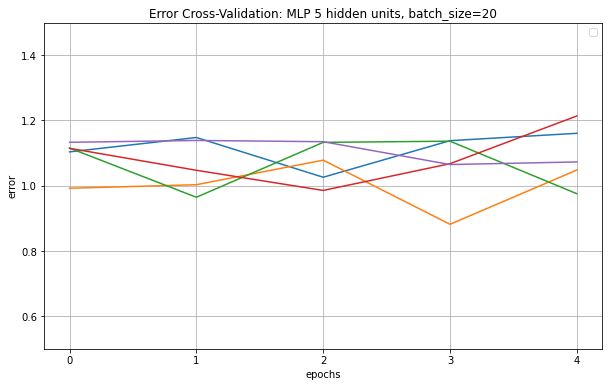

In [66]:
plt.figure(figsize=(10,6))

for p in error:
    plt.plot(p)

plt.title('Error Cross-Validation: MLP 5 hidden units, batch_size=20')
plt.xticks(np.arange(folds))
plt.legend()
plt.grid()
plt.xlabel('epochs')
plt.ylabel('error')
plt.ylim([0.5,1.5])

# plt.savefig(path_graphs + 'error_cv5_mlp5_bn20.jpg', format='jpg', dpi=200)

##### Grid Search

In [227]:
# scaling/normalization
normalizer = preprocessing.MinMaxScaler()
train_data.data = normalizer.fit_transform(train_data.data)

# model
model = NeuralNetwork(22,3)

# loss function
weights_class = np.mean(train_data.labels.numpy(),axis=0)
criterion = nn.CrossEntropyLoss()

# optimizer
learning_rate = 1e-1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# cross-validation
folds = 5
kfold = model_selection.KFold(n_splits=folds,shuffle=True,random_state=0)

In [228]:
error, accuracy_train, accuracy_test, confusion_matrix = train_wCrossValidation(model,criterion, optimizer, train_data, epochs)

Ep 1/5, it 88/88: loss train: 0.98, accuracy train: 0.45, accuracy test: 0.11
Ep 2/5, it 88/88: loss train: 1.04, accuracy train: 0.52, accuracy test: 0.11
Ep 3/5, it 88/88: loss train: 0.98, accuracy train: 0.54, accuracy test: 0.11
Ep 4/5, it 88/88: loss train: 0.84, accuracy train: 0.55, accuracy test: 0.10
Ep 5/5, it 88/88: loss train: 0.96, accuracy train: 0.54, accuracy test: 0.11
Fold 1/5: loss train: 0.96, accuracy train: 0.52, accuracy test: 0.11

Ep 1/5, it 88/88: loss train: 1.04, accuracy train: 0.40, accuracy test: 0.10
Ep 2/5, it 88/88: loss train: 0.94, accuracy train: 0.51, accuracy test: 0.09
Ep 3/5, it 88/88: loss train: 0.92, accuracy train: 0.52, accuracy test: 0.10
Ep 4/5, it 88/88: loss train: 0.79, accuracy train: 0.54, accuracy test: 0.10
Ep 5/5, it 88/88: loss train: 0.85, accuracy train: 0.54, accuracy test: 0.10
Fold 2/5: loss train: 0.91, accuracy train: 0.50, accuracy test: 0.10

Ep 1/5, it 88/88: loss train: 0.92, accuracy train: 0.48, accuracy test: 0.10


In [241]:
# scaling/normalization
scalers = [preprocessing.MinMaxScaler(), preprocessing.Normalizer(), 
                preprocessing.MaxAbsScaler(), preprocessing.StandardScaler()]

# model
model = NeuralNetwork(22,3)

# loss function
weights_class = torch.tensor(np.mean(train_data.labels.numpy(),axis=0))
criterion = [nn.CrossEntropyLoss(), nn.CrossEntropyLoss(weight=weights_class)]

# optimizer
learning_rate = [0.5,0.1,1e-2]
momentum = [0.01,0.1,0.5,0.9]
nesterov = dampening = [True, False]
optimizer = torch.optim.SGD

# cross-validation
folds = 5
kfold = model_selection.KFold(n_splits=folds,shuffle=True,random_state=0)

In [ ]:
def grid_search():
    return

In [245]:
hyperparams = np.array(np.meshgrid(scalers,criterion,learning_rate,momentum,nesterov,dampening)).T.reshape((-1,6))

In [247]:
hyperparams.shape

(384, 6)

In [ ]:
train_data.data = scaler.fit_transform(train_data.data)


In [222]:
a1 = ['hol','QUE TAL']
a2 = [1,2,3,5]
np.array(np.meshgrid(a1,a2)).T.reshape((-1,2))

array([['hol', '1'],
       ['hol', '2'],
       ['hol', '3'],
       ['hol', '5'],
       ['QUE TAL', '1'],
       ['QUE TAL', '2'],
       ['QUE TAL', '3'],
       ['QUE TAL', '5']], dtype='<U11')